In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pic
import functools

from scipy import stats

import sys
sys.path.append('/data/yosef2/users/mattjones/projects/metastasis/MetastasisTracing/')
import utilities.de_utils as de_utils

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [6]:
path = "/data/yosef2/users/mattjones/projects/metastasis/A549_Day0/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta_5k = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta_fixed.txt", sep='\t', index_col = 0)
meta_Day0 = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/A549_Day0/Day0_meta.txt", sep='\t', index_col = 0)

tumor_to_met = meta_5k[["LineageGroup", 'TissueDispersion', 'TreeMetRate']].drop_duplicates(subset=['LineageGroup']).reset_index().copy()
meta_Day0['TreeMetRate'] = meta_Day0.apply(lambda x: tumor_to_met.loc[x.LineageGroup, 'TreeMetRate'] if x.LineageGroup in tumor_to_met.index.values else np.nan, axis=1)

gene_list = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/A549_Day0/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values

sigscores = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/A549_Day0/A549_Day0_sigscores.txt", sep='\t', index_col = 0)
adata.shape

(8726, 33694)

In [7]:
adata.shape

(8726, 33694)

In [8]:
meta_Day0[~meta_Day0['LineageGroup'].isna()].head(5)


LineageGroup  DynamicMetScore  percent_mito     nUMI  \
0                                                                          
AAAGATGAGACCGGAT-1          15.0         0.066573      0.037368  19027.0   
AAAGATGAGTTGTAGA-1          15.0         0.066573      0.042322   8388.0   
AAAGATGGTTTGTGTG-1          15.0         0.066573      0.045635  40408.0   
AAAGTAGAGGGTCTCC-1          30.0         0.169605      0.047254  33225.0   
AAAGTAGCAGGGCATA-1          18.0              NaN      0.043048  11406.0   

                    n_genes LG_Present  TreeMetRate  
0                                                    
AAAGATGAGACCGGAT-1     3652  Engrafted     0.129666  
AAAGATGAGTTGTAGA-1     2112  Engrafted     0.129666  
AAAGATGGTTTGTGTG-1     5510  Engrafted     0.129666  
AAAGTAGAGGGTCTCC-1     5385  Engrafted     0.078704  
AAAGTAGCAGGGCATA-1     2934  Engrafted          NaN

In [9]:
meta_Day0.head(5)

LineageGroup  DynamicMetScore  percent_mito     nUMI  \
0                                                                          
AAACCTGAGAGGTTAT-1           NaN              NaN      0.032169  29314.0   
AAACCTGAGCAGGTCA-1           NaN              NaN      0.043743  38338.0   
AAACCTGAGGCAAAGA-1           NaN              NaN      0.052378  23483.0   
AAACCTGAGTGGAGAA-1           NaN              NaN      0.035219  29728.0   
AAACCTGCACCAACCG-1           NaN              NaN      0.043608  42928.0   

                    n_genes    LG_Present  TreeMetRate  
0                                                       
AAACCTGAGAGGTTAT-1     5088  NotEngrafted          NaN  
AAACCTGAGCAGGTCA-1     5181  NotEngrafted          NaN  
AAACCTGAGGCAAAGA-1     4147  NotEngrafted          NaN  
AAACCTGAGTGGAGAA-1     4961  NotEngrafted          NaN  
AAACCTGCACCAACCG-1     5349  NotEngrafted          NaN

In [10]:
cols = ['LineageGroup', 'TreeMetRate']
all_meta = meta_Day0[cols]


In [11]:
all_meta.index.name = 'cellBC'

In [12]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1
adata.obs.index.name = 'cellBC'

adata.obs = adata.obs.merge(all_meta[['LineageGroup', 'TreeMetRate']], left_index=True, right_index=True, how='left')


In [14]:
umap = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/A549_Day0/A549_Day0_umap.txt", sep='\t', index_col = 0)
# umap = pd.read_csv("RNA_5k30kDay0/harmonized_umap.txt", sep='\t', index_col = 0)
# umap = pd.read_csv('RNA_5k30kDay0/harmonized_umap.Day05k.txt', sep='\t', index_col = 0)

adata.obsm['X_umap'] = umap.values

In [15]:
# adata = adata[adata.obs.percent_mito < 0.05, :]

In [16]:
sc.pp.normalize_total(adata, target_sum = 1e6)

In [17]:
adata.raw = adata

In [18]:
sc.pp.log1p(adata)

In [19]:
adata.obs['LG_Present'] = 'NotEngrafted'
adata.obs.loc[(~(adata.obs['LineageGroup'].isna()) & (adata.obs['LineageGroup'] != 'nan')), 'LG_Present'] = 'Engrafted'

adata.obs['LG_Present'] = adata.obs["LG_Present"].astype('category')

/home/eecs/mattjones/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [20]:
adata.obs.groupby('LG_Present').agg({'LG_Present': 'count'}).divide(adata.obs.shape[0])

LG_Present
LG_Present              
Engrafted       0.083773
NotEngrafted    0.916227

In [21]:
adata.obs['MetSigScore'] = sigscores.loc[adata.obs.index.values, 'MetSignature']

sigscores.head(5)

MetUp   MetDown  MetSignature  MetUpSmall  \
AAACCTGAGAGGTTAT-1  3.031203  2.502679      0.269132    2.830261   
AAACCTGAGCAGGTCA-1  3.584945  2.897068      0.354616    3.239867   
AAACCTGAGGCAAAGA-1  3.389451  2.362756      0.552914    3.336243   
AAACCTGAGTGGAGAA-1  3.140286  2.356689      0.415330    2.956493   
AAACCTGCACCAACCG-1  3.158252  2.708174      0.222234    2.824777   

                    MetDownSmall  MetSignatureSmall  \
AAACCTGAGAGGTTAT-1      1.176193           1.071330   
AAACCTGAGCAGGTCA-1      1.469250           1.172450   
AAACCTGAGGCAAAGA-1      0.864171           1.492159   
AAACCTGAGTGGAGAA-1      0.629481           1.382163   
AAACCTGCACCAACCG-1      1.131788           1.087748   

                    HALLMARK_TNFA_SIGNALING_VIA_NFKB  HALLMARK_HYPOXIA  \
AAACCTGAGAGGTTAT-1                          0.576005          0.555159   
AAACCTGAGCAGGTCA-1                          0.534858          0.688761   
AAACCTGAGGCAAAGA-1                          0.367062          0.592168   
AAACCTGAGTGGAGAA-1                          0.460113          0.589298   
AAACCTGCACCAACCG-1                          0.468563          0.544333   

                    HALLMARK_CHOLESTEROL_HOMEOSTASIS  \
AAACCTGAGAGGTTAT-1                          0.889351   
AAACCTGAGCAGGTCA-1                          1.103675   
AAACCTGAGGCAAAGA-1                          0.790367   
AAACCTGAGTGGAGAA-1                          1.450383   
AAACCTGCACCAACCG-1                          0.744243   

                    HALLMARK_MITOTIC_SPINDLE  ...  \
AAACCTGAGAGGTTAT-1                  0.829391  ...   
AAACCTGAGCAGGTCA-1                  0.453075  ...   
AAACCTGAGGCAAAGA-1                  0.508033  ...   
AAACCTGAGTGGAGAA-1                  0.609637  ...   
AAACCTGCACCAACCG-1                  0.667391  ...   

                    FARMER_BREAST_CANCER_CLUSTER_6  \
AAACCTGAGAGGTTAT-1                        0.338472   
AAACCTGAGCAGGTCA-1                        0.665546   
AAACCTGAGGCAAAGA-1                       -0.031709   
AAACCTGAGTGGAGAA-1                        0.774405   
AAACCTGCACCAACCG-1                        0.196959   

                    FARMER_BREAST_CANCER_CLUSTER_5  \
AAACCTGAGAGGTTAT-1                        0.488865   
AAACCTGAGCAGGTCA-1                        0.307076   
AAACCTGAGGCAAAGA-1                        0.279564   
AAACCTGAGTGGAGAA-1                        0.805608   
AAACCTGCACCAACCG-1                        0.317102   

                    FARMER_BREAST_CANCER_CLUSTER_4  \
AAACCTGAGAGGTTAT-1                       -0.280254   
AAACCTGAGCAGGTCA-1                       -0.094340   
AAACCTGAGGCAAAGA-1                       -0.310684   
AAACCTGAGTGGAGAA-1                       -0.166512   
AAACCTGCACCAACCG-1                       -0.172963   

                    FARMER_BREAST_CANCER_CLUSTER_3  EPPERT_LSC_R  \
AAACCTGAGAGGTTAT-1                        0.443340      0.329699   
AAACCTGAGCAGGTCA-1                        0.380161      0.085824   
AAACCTGAGGCAAAGA-1                        0.926069      0.216298   
AAACCTGAGTGGAGAA-1                        0.325414      0.520513   
AAACCTGCACCAACCG-1                        0.546264      0.414351   

                    EPPERT_HSC_R  EPPERT_PROGENITOR  EPPERT_CE_HSC_LSC  \
AAACCTGAGAGGTTAT-1      0.268000           0.852786           0.164223   
AAACCTGAGCAGGTCA-1      0.391644           0.500249           0.028191   
AAACCTGAGGCAAAGA-1      0.228929           0.619162           0.109692   
AAACCTGAGTGGAGAA-1      0.310049           0.804610           0.084059   
AAACCTGCACCAACCG-1      0.209917           0.594686           0.007011   

                    QUINTENS_EMBRYONIC_BRAIN_RESPONSE_TO_IR  \
AAACCTGAGAGGTTAT-1                                 0.393070   
AAACCTGAGCAGGTCA-1                                 0.521867   
AAACCTGAGGCAAAGA-1                                 0.355087   
AAACCTGAGTGGAGAA-1                                 0.380411   
AAACCTGCACCAACCG-1                    

In [22]:
adata.uns['LG_Present_colors'] = ['#FF2400', '#eeeeee']

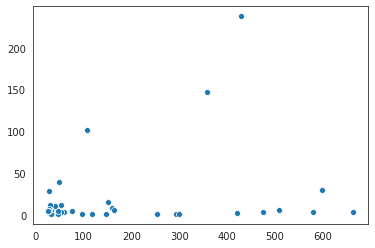

SpearmanrResult(correlation=-0.05296248843734649, pvalue=0.7625277280181244)

In [23]:
clone_sizes_5k = meta_5k.groupby('LineageGroup').agg({'LineageGroup': 'count'})
clone_sizes_day0 = adata.obs.groupby('LineageGroup').agg({'LineageGroup': 'count'})

mouse, day0 = [], []
for clone in clone_sizes_day0.index.values:
    if clone not in [1,2,3]:
        mouse.append(clone_sizes_5k.loc[clone, 'LineageGroup'])
        day0.append(clone_sizes_day0.loc[clone, 'LineageGroup'])
        
sns.scatterplot(mouse, day0)
plt.show()

stats.spearmanr(mouse, day0)

... storing 'gene_ids' as categorical


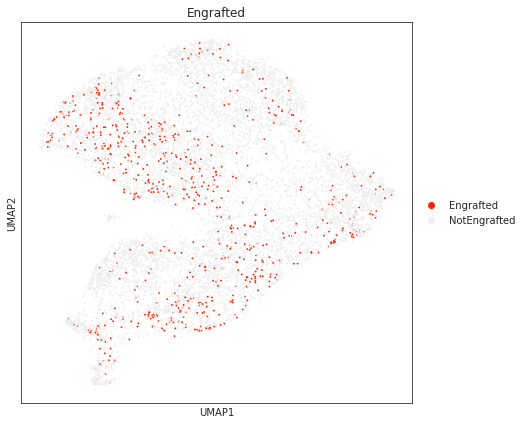

<Figure size 504x504 with 0 Axes>

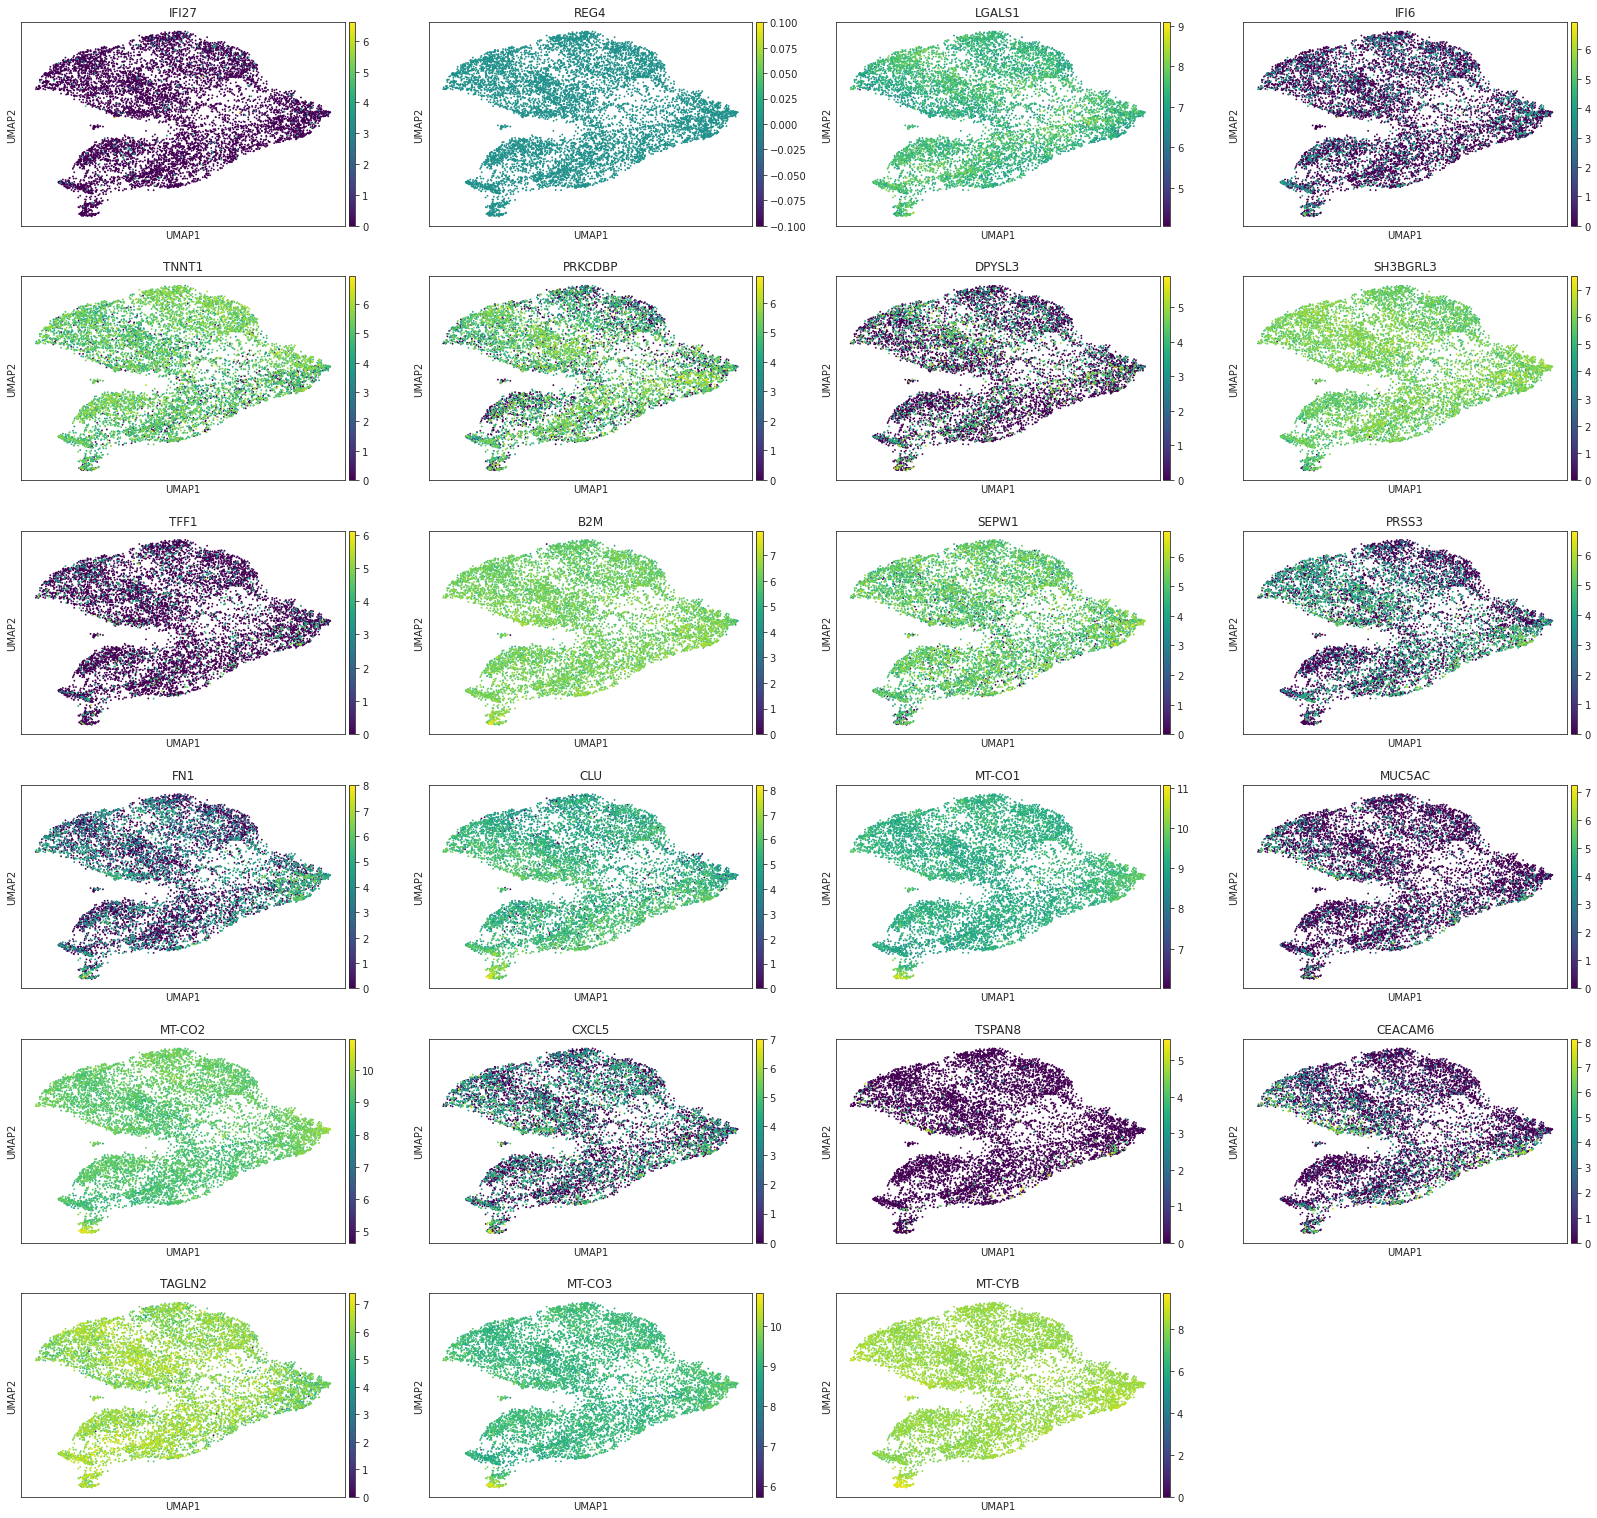

<Figure size 504x504 with 0 Axes>

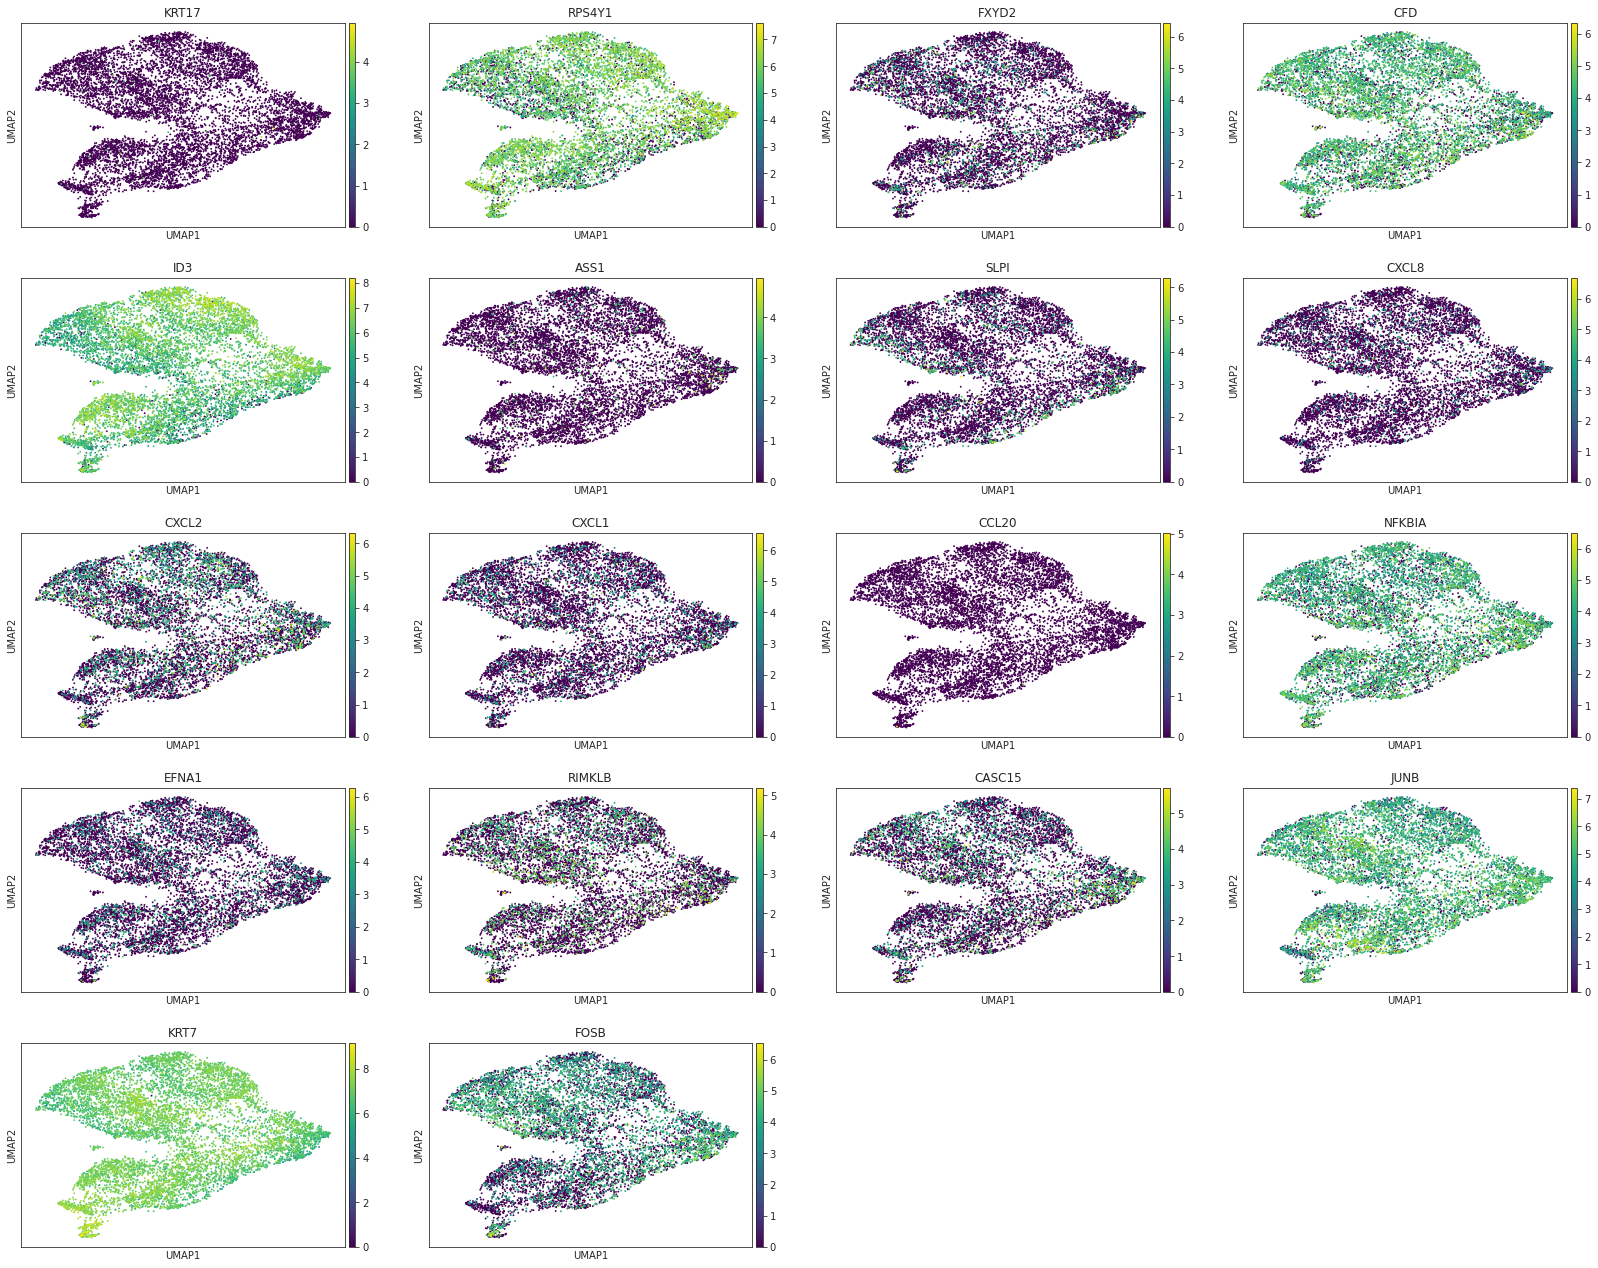

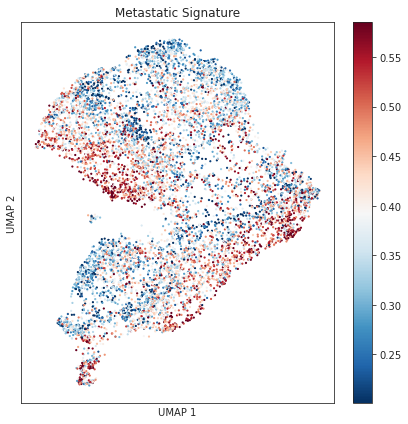

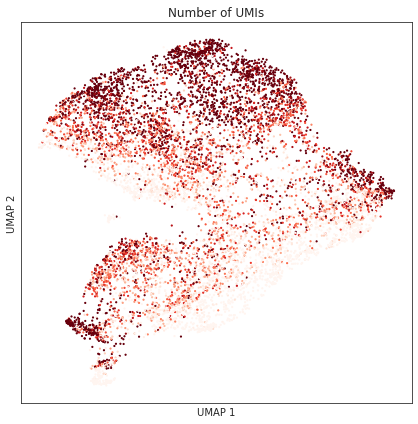

In [24]:
# h = plt.figure(figsize = (7,7))
# ax = sc.pl.umap(adata, color = "louvain", show = False)
# plt.title("Louvain Clustering")
# plt.show()

fig = plt.figure(figsize = (7,7))
ax = plt.gca()
sc.pl.umap(adata, color = "LG_Present", show = False, ax=ax)
plt.title("Engrafted")
# plt.savefig('figs/Day0_engrafted.eps', bbox_inches='tight')
plt.show()


h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = ['IFI27', 'REG4', 'LGALS1', 'IFI6', 'TNNT1', 'PRKCDBP', 'DPYSL3', 'SH3BGRL3', 'TFF1', 'B2M',
                               'SEPW1', 'PRSS3', 'FN1', 'CLU', 'MT-CO1', 'MUC5AC', 'MT-CO2', 'CXCL5', 'TSPAN8', 'CEACAM6',
                               'TAGLN2', 'MT-CO3', 'MT-CYB'], cmap='viridis', use_raw=False, show = False)
# plt.savefig('day0_metgenes_up.png')
plt.show()

h = plt.figure(figsize = (7,7))
ax = sc.pl.umap(adata, color = ['KRT17', 'RPS4Y1', 'FXYD2', 'CFD', 'ID3','ASS1', 'SLPI', 'CXCL8',
                               'CXCL2', 'CXCL1', 'CCL20', 'NFKBIA', 'EFNA1', 'RIMKLB', 'CASC15', 'JUNB', 'KRT7', 'FOSB'], 
                                cmap = 'viridis', use_raw=False, show = False)
# plt.savefig('day0_metgenes_down.png')
plt.show()

fig = plt.figure(figsize=(7,7))
ax = plt.gca()
ss = sigscores.loc[adata.obs.index.values, 'MetSignature']
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], cmap = 'RdBu_r', s = 12000 / adata.shape[0],
                            c = ss, vmin=np.percentile(ss, 5), vmax = np.percentile(ss, 95))
plt.title("Metastatic Signature")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
ax.set_yticks([])
ax.set_xticks([])
plt.colorbar()
# plt.savefig('figs/Day0_umap_treemetsig.colorbar.eps', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(7,7))
ax = plt.gca()
ss = adata.obs['nUMI'].to_numpy()
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], cmap = 'Reds', s = 12000 / adata.shape[0],
                            c = ss, vmin=np.percentile(ss, 25), vmax = np.percentile(ss, 75))
plt.title("Number of UMIs")
plt.xlabel('UMAP 1')
plt.ylabel("UMAP 2")
ax.set_yticks([])
ax.set_xticks([])
# plt.colorbar()
# plt.savefig('figs/Day0_umap_nUMI.eps',bbox_inches='tight')
plt.show()


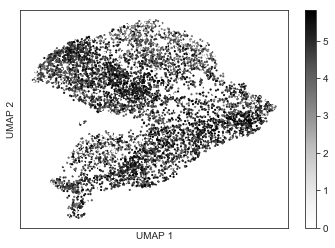

<Figure size 432x288 with 0 Axes>

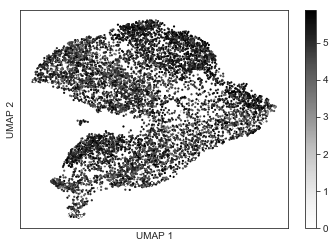

<Figure size 432x288 with 0 Axes>

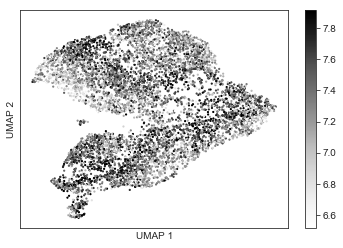

<Figure size 432x288 with 0 Axes>

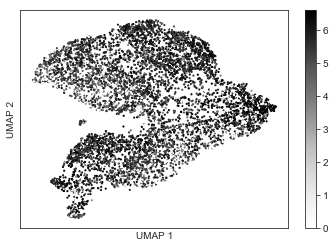

<Figure size 432x288 with 0 Axes>

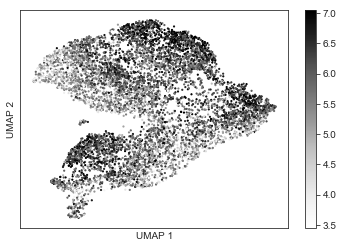

<Figure size 432x288 with 0 Axes>

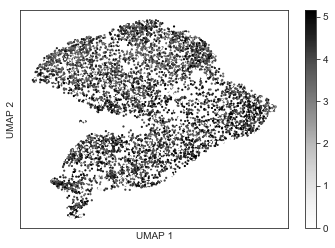

<Figure size 432x288 with 0 Axes>

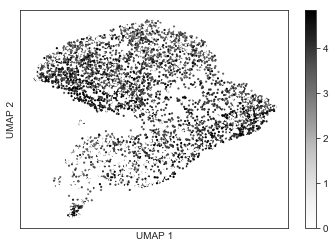

<Figure size 432x288 with 0 Axes>

In [140]:
## Plot specific up/down genes on square panels

# up_genes = ['IFI6', 'PRKCDBP', 'MUC5AC', 'LGALS1', 'TNNT1', 'CLU', 'FN1', 'CEACAM6','CXCL5']
# dwn_genes = ['RPS4Y1', 'ID3', 'CFD', 'NFKBIA', 'KRT7', 'FOSB', 'CXCL2']

for g in ['PRKCDBP', 'TNNT1', 'LGALS1', 'RPS4Y1', 'ID3', "NFKBIA", 'FOSB']:
    fig, ax1 = plt.subplots(ncols=1)
    # fig = plt.figure(figsize=(7,7))
    # ax = plt.gca()
    ss = np.asarray(adata.X[:, np.where(adata.var_names == g)[0]].todense()).reshape(-1)
    p = ax1.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], cmap = 'Greys', s = 12000 / adata.shape[0],
                                 c = ss, vmin=np.percentile(ss, 5), vmax = np.percentile(ss, 95))
    

    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel("UMAP 2")
    ax1.set_yticks([])
    ax1.set_xticks([])
    
    fig.colorbar(p, ax=ax1)
    ax1.set_aspect('auto')
    plt.savefig(f'figs/Day0markers/{g}.eps')
    plt.show()


RanksumsResult(statistic=4.808002906563138, pvalue=1.524455499214124e-06)

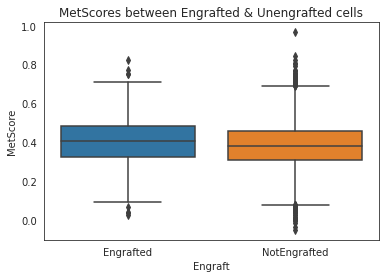

In [25]:
ss = pd.DataFrame.from_dict({'MetScore': sigscores.loc[adata.obs.index.values, 'MetSignature'], 'Engraft': adata.obs['LG_Present']})
sns.boxplot(data=ss, x = 'Engraft', y = "MetScore")
plt.title("MetScores between Engrafted & Unengrafted cells")
# plt.savefig('metscore_engraft_vs_nonengraft.eps')

wilcoxon = stats.ranksums(ss.loc[ss['Engraft'] == 'Engrafted', 'MetScore'], ss.loc[ss['Engraft'] == 'NotEngrafted', 'MetScore'])
wilcoxon

## Evaluate transcriptional programs of metastatic clones in Day0 Sample

In [214]:
at = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/ALL.5k.FINISHED.alleleTable.txt", sep='\t')

In [133]:
LG2intBC = at.groupby('LineageGroup').agg({'intBC': 'unique'})['intBC'].to_dict()

In [134]:
pivLM0_bin = cell_intBC_piv.copy()
pivLM0_bin[pivLM0_bin>0]=1
pivLM0_sums = pivLM0_bin.sum(axis=0)
pivLM0_sums.head()

CTCACCGCTATTTG    410.0
AATCCATGTCGTGT    345.0
GTTGCTACTTGCGG    343.0
TCAACCAGTTAGTT    342.0
CCCGGATGTGAGGT    342.0
dtype: float64

In [227]:
cell_intBC_piv.fillna(0, inplace=True)
cell_intBC_piv_norm = cell_intBC_piv.div(cell_intBC_piv.sum(axis=1), axis=0)
cell_intBC_piv_norm.head(5)

CTCACCGCTATTTG  AATCCATGTCGTGT  GTTGCTACTTGCGG  \
cellBC                                                               
AAACCTGAGAGGTTAT-1             0.0             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0             0.0             0.0   

                    TCAACCAGTTAGTT  CCCGGATGTGAGGT  GTTAGTTGATGAGG  \
cellBC                                                               
AAACCTGAGAGGTTAT-1             0.0             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0             0.0             0.0   

                    TCGTTGGACATTCG  GTTTTATACGGTTA  AAATCCGTATTGTG  \
cellBC                                                               
AAACCTGAGAGGTTAT-1             0.0             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0             0.0             0.0   

                    GCTAGATCCTCAAT  ...  GGCCATCCGTCTAT  GGCCATGTCACAGG  \
cellBC                              ...                                   
AAACCTGAGAGGTTAT-1             0.0  ...             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0  ...             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0  ...             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0  ...             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0  ...             0.0             0.0   

                    GGCCCACGCACCTG  GGCCCAGTCTTTAC  GGCCCATCCTAACC  \
cellBC                                                               
AAACCTGAGAGGTTAT-1             0.0             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0             0.0             0.0   

                    GGCCCCATTTATCT  GGCCCCCTTACCGG  GGCCCCGGATAGGC  \
cellBC                                                               
AAACCTGAGAGGTTAT-1             0.0             0.0             0.0   
AAACCTGAGCAGGTCA-1             0.0             0.0             0.0   
AAACCTGAGCCATCGC-1             0.0             0.0             0.0   
AAACCTGAGGCAAAGA-1             0.0             0.0             0.0   
AAACCTGAGTGGAGAA-1             0.0             0.0             0.0   

                    GGCCCCTCAAACGA  AAAAAACTCCAATG  
cellBC                                              
AAACCTGAGAGGTTAT-1             0.0             0.0  
AAACCTGAGCAGGTCA-1             0.0             0.0  
AAACCTGAGCCATCGC-1             0.0             0.0  
AAACCTGAGGCAAAGA-1             0.0             0.0  
AAACCTGAGTGGAGAA-1             0.0             0.0  

[5 rows x 32302 columns]

In [228]:
intBCs_to_consider = list(set(functools.reduce(lambda x, y: np.concatenate((x, y)), [vals for vals in LG2intBC.values()])))

intBCs_to_consider = np.intersect1d(intBCs_to_consider, cell_intBC_piv_norm.columns)
cell_intBC_piv_norm_filt = cell_intBC_piv_norm[intBCs_to_consider].replace(np.nan, 0)

In [229]:
dfLG2intBC = pd.DataFrame(np.zeros((100, len(intBCs_to_consider))), index = range(1, 101), columns = intBCs_to_consider)

for ind in dfLG2intBC.index:
    
    intBCs = np.intersect1d(intBCs_to_consider, LG2intBC[ind])
    
    dfLG2intBC.loc[ind, intBCs] = 1
    

In [230]:
dfLM0cellsC2LG = cell_intBC_piv_norm_filt.dot(dfLG2intBC.T).replace(np.nan, 0).astype(float)

In [231]:
dfLM0cellsC2LG.head(5)

1    2    3    4    5    6    7    8    9    10   ...  \
cellBC                                                                ...   
AAACCTGAGAGGTTAT-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AAACCTGAGCAGGTCA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AAACCTGAGCCATCGC-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AAACCTGAGGCAAAGA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
AAACCTGAGTGGAGAA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                    91   92   93   94   95   96   97   98   99   100  
cellBC                                                                
AAACCTGAGAGGTTAT-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AAACCTGAGCAGGTCA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AAACCTGAGCCATCGC-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AAACCTGAGGCAAAGA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
AAACCTGAGTGGAGAA-1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 100 columns]

In [289]:
KINSHIP_FILTER = 0.75
cell_to_lg = dfLM0cellsC2LG[dfLM0cellsC2LG > KINSHIP_FILTER].idxmax(axis=1).to_frame()
cell_to_lg.columns = ['LineageGroup']

In [216]:
cell_to_lg[~(cell_to_lg['LineageGroup'].isna())].shape[0] / cell_to_lg.shape[0]

NameError: name 'cell_to_lg' is not defined

In [110]:
low_met_clones = [78, 96, 94, 46, 85]
high_met_clones = [1, 66, 8, 26, 90]

ss = sigscores.loc[adata.obs.index.values, 'MetDown']

for col in ["MetUp", "MetDown", "MetSig"]:
    tumor_to_met[col] = None

for cp in tumor_to_met.index:
    
    cells = cell_to_lg[cell_to_lg['LineageGroup'] == cp].index.to_numpy()
    cells = np.intersect1d(cells, sigscores.index.values)
    if len(cells):
        tumor_to_met.loc[cp, 'MetUp'] = sigscores.loc[cells, 'MetUp'].mean()
        tumor_to_met.loc[cp, 'MetDown'] = sigscores.loc[cells, "MetDown"].mean()
        tumor_to_met.loc[cp, 'MetSig'] = sigscores.loc[cells, "MetSignature"].mean()
        
tumor_to_met.index = tumor_to_met.LineageGroup

NameError: name 'cell_to_lg' is not defined

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


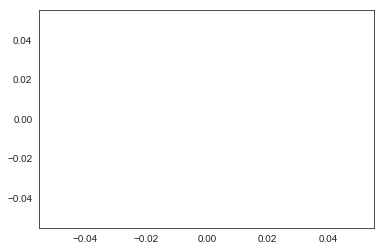

In [217]:
tumor_to_met_filt = tumor_to_met[~tumor_to_met['MetDown'].isna()]
tumor_to_met_filt = tumor_to_met_filt[~tumor_to_met['DynamicMetScore'].isna()]

sns.scatterplot(tumor_to_met_filt['DynamicMetScore'], tumor_to_met_filt['MetSig'])

### Perform differential expression tests

In [27]:
# add in met scores and LG assignments to obs
# adata.obs['LineageGroup'] = 'nan'

# cells_to_assign = np.intersect1d(adata.obs.index.values, cell_to_lg.index.values)
# adata.obs.loc[cells_to_assign, 'LineageGroup'] = cell_to_lg.loc[cells_to_assign, 'LineageGroup']

adata.obs['TreeMetRate'] = adata.obs.apply(
    lambda x: tumor_to_met.loc[x.LineageGroup, 'TreeMetRate'] if x.LineageGroup in tumor_to_met.index.values else np.nan, axis=1)

adata.obs['LG_Present'] = 'NotEngrafted'
adata.obs.loc[(~(adata.obs['LineageGroup'].isna()) & (adata.obs['LineageGroup'] != 'nan')), 'LG_Present'] = 'Engrafted'

adata.obs['LG_Present'] = adata.obs["LG_Present"].astype('category')

/home/eecs/mattjones/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### First test DE between those that engrafted and those that did not


In [28]:
sc.tl.rank_genes_groups(adata, 'LG_Present', use_raw=True, groups=['Engrafted'], reference='NotEngrafted', method='wilcoxon', n_genes=7000, only_positive=False)

/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:325: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:325: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/home/eecs/mattjones/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:332: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [29]:
result = adata.uns["rank_genes_groups"]
groups = result['names'].dtype.names

de = de_utils.create_DE_df(adata, "LG_Present", "Engrafted", "NotEngrafted", result)
de.index = de['gene']
# met_de.to_csv("data/10k/high_met_de.txt", sep='\t')
# de = de[de['qval'] < 0.05]

unique_genes = de_utils.consolidate_genes([de])

# met_de_bulk = de_utils.bulk_by_group(adata.obs['LG_Present'], adata, unique_genes)

(8726, 33694) 8726 [False False False False False False False False False False]


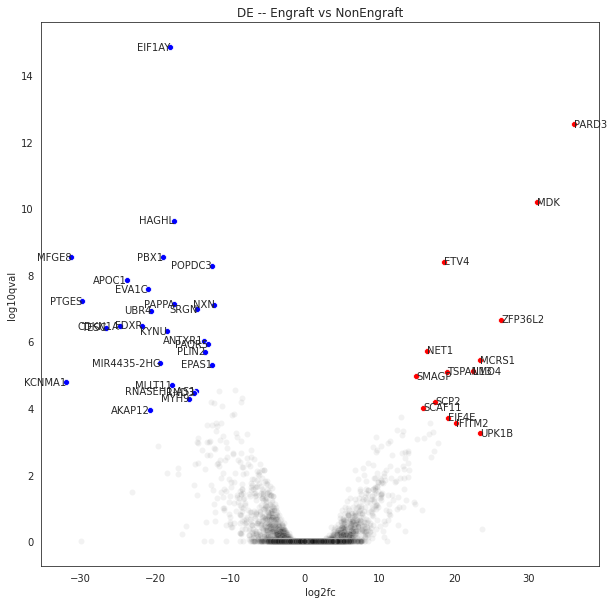

In [30]:
de = de[((~de['log2fc'].isna()) & (np.isfinite(de['log2fc'])))]
de = de[~de['qval'].isna()]

de['log10qval'] = -np.log10(de['qval'])
de['log10qval'] = de.apply(lambda x: min(350, x.log10qval), axis=1)

discScore = lambda z,p: p * np.abs(z)

pseudoStd = np.std(de['log2fc'])
de.loc[:,'thresh'] = discScore(de['log2fc']/pseudoStd, de['log10qval'])

thresh_val = 15

fig, axis = plt.subplots(1,1, figsize=(10, 10))
sns.scatterplot(x='log2fc', y = 'log10qval', data=de.loc[((de['thresh'] >= thresh_val) & (de['log2fc'] >=0))], color='red')
sns.scatterplot(x='log2fc', y = 'log10qval', data=de.loc[((de['thresh'] >= thresh_val) & (de['log2fc'] < 0))], color='blue')
sns.scatterplot(x='log2fc', y = 'log10qval', data=de.loc[de['thresh'] < thresh_val], color='black', alpha=0.05)
for gene, row in de.loc[de['thresh'] >= thresh_val].iterrows():
    
    axis.text(row['log2fc']+0.01, row['log10qval']+0.01, gene, fontsize=10,
    horizontalalignment = 'left' if row['log2fc'] > 0 else 'right', verticalalignment='center')
    
plt.title("DE -- Engraft vs NonEngraft")
plt.show()

### Evaluate differences between high metastatic and low metastatic clones

In [32]:
adata_sub = adata[~adata.obs['TreeMetRate'].isna()]

# split cells into top and bottom
top_perc = np.percentile(adata_sub.obs['TreeMetRate'], 50)
bot_perc = np.percentile(adata_sub.obs['TreeMetRate'], 50)
midperc = np.percentile(adata_sub.obs['TreeMetRate'], 50)
adata_sub = adata_sub[((adata_sub.obs['TreeMetRate'] >= top_perc) | (adata_sub.obs['TreeMetRate'] <= bot_perc))]
adata_sub.obs['Groupby'] = adata_sub.obs.apply(lambda x: 'High' if x.TreeMetRate >= top_perc else 'Low', axis=1)

Trying to set attribute `.obs` of view, making a copy.


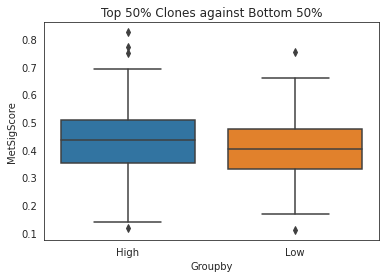

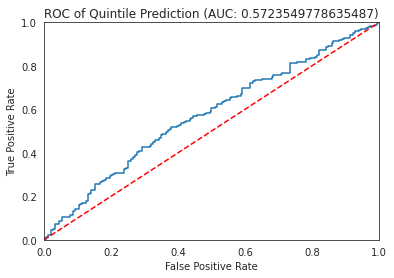

MannwhitneyuResult(statistic=30137.0, pvalue=0.0026225433341233568)

In [34]:
from sklearn import metrics

sns.boxplot(data=adata_sub.obs, x = 'Groupby', y = "MetSigScore")
plt.title('Top 50% Clones against Bottom 50%')
# plt.savefig("metscore_metclones_vs_nonmetclones.5k.eps")
plt.show()


fpr, tpr, thresholds = metrics.roc_curve(adata_sub.obs['Groupby'].map({'Low': 0, 'High': 1}), adata_sub.obs['MetSigScore'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC of Quintile Prediction (AUC: {metrics.auc(fpr, tpr)})")
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.savefig("metscore_median_roc.eps")
plt.show()

metrics.auc(fpr, tpr)


wilcoxon = stats.mannwhitneyu(adata_sub.obs.loc[adata_sub.obs['Groupby'] == 'High', 'MetSigScore'],
                          adata_sub.obs.loc[adata_sub.obs['Groupby'] == 'Low', 'MetSigScore'])
wilcoxon

## Evaluate consistency of metastatic rates of clones in different mice

In [117]:
## read in 10k and 100k clonal met rate measurments

metrate_10k = pd.read_csv("../MetastasisTracing/data/lg_metastatic_scoresAllele.10k.txt", sep='\t', index_col = 0)
metrate_100k = pd.read_csv("../MetastasisTracing/data/lg_metastatic_scoresAllele.100k.txt", sep='\t', index_col = 0)

In [10]:
metrate_10k['TreeMetRate']

1     0.001040
13    0.106796
6     0.181818
2     0.183283
8     0.494382
10    0.135135
5     0.139313
7     0.155425
12    0.117117
4     0.240113
9     0.152610
3     0.208841
11    0.084507
Name: TreeMetRate, dtype: float64

In [469]:
def permutation_test(mr1, mr2, pair, B=10000, _SEED=1234):
    """Computes the emprical p-value of the difference in Metrates between clones in the pair.
    
    Args:
        mr1: pd.Series of met rates
        mr2: pd.Series of met rates
        pair: a tuple of two clones to compare. Assume pair[0] in mr1 and pair[1] in mr2.
        B: number of random pairs to select
        
    Returns:
        The difference & the empirical p-value
    """
    prng = np.random.RandomState(_SEED)
    diff_dist = []
    
    diff = abs(mr1.loc[pair[0]] - mr2.loc[pair[1]])
    
    c1, c2 = pair[0], pair[1]
    
    mr1, mr2 = mr1.copy(), mr2.copy()
    p = 0
    for i in range(B):
        
        
        mr1.index = prng.permutation(mr1.index)
        mr2.index = prng.permutation(mr2.index)
        
        diff_emp = abs(mr1.loc[c1] - mr2.loc[c2])
        diff_dist.append(diff_emp)
        if diff_emp < diff:
            p += 1
            
        i += 1
            
    return diff, p/B, diff_dist

In [121]:
# compute background
def get_pairwise_deltas(list1, list2):
    
    deltas = []
    for i in list1:
        for j in list2:
            deltas.append(abs(i - j))
            
    return deltas


(0, 0.05)

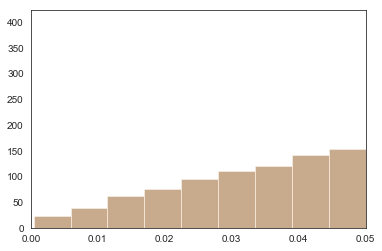

In [125]:
deltas = get_pairwise_deltas(metrate_10k['TreeMetRate'].values, metrate_100k['TreeMetRate'].values)
sns.distplot(deltas, hist_kws={'cumulative': True, 'rwidth': 1.0}, kde=False, bins=100)


# deltas = get_pairwise_deltas(metrate_10k['TreeMetRate'].values, metrate_100k['TreeMetRate'].values)
sns.distplot(deltas, hist_kws={'cumulative': True, 'rwidth': 1.0}, kde=False, bins=100)
plt.xlim(0, 0.05)

In [477]:
# compare 10k Clone 5 and 100k Clone 4

deltas = np.array(get_pairwise_deltas(metrate_10k['TreeMetRate'].values, metrate_100k['TreeMetRate'].values))

ret = permutation_test(metrate_10k['TreeMetRate'], metrate_100k['TreeMetRate'], (5, 4))
print(f'10k CP005, 100k CP004: Difference = {ret[0]}, pval = {ret[1]}')

cmp1 = ret[0]
print(f"true p: {len(np.where(deltas <= ret[0])[0]) / len(deltas)}")

print(f"Delta / median(background): {ret[0] / np.median(deltas)}")


# # compare 10k Clone 7 and 100k Clone 11
ret = permutation_test(metrate_10k['TreeMetRate'], metrate_100k['TreeMetRate'], (7, 11))
print(f'10k CP007, 100k CP011: Difference = {ret[0]}, pval = {ret[1]}')

cmp2 = ret[0]
print(f"true p: {len(np.where(deltas <= ret[0])[0]) / len(deltas)}")
print(f"Delta / median(background): {ret[0] / np.median(deltas)}")




10k CP005, 100k CP004: Difference = 0.0004974494410477093, pval = 0.0023
true p: 0.004962779156327543
Delta / median(background): 0.006788102929285259
10k CP007, 100k CP011: Difference = 0.002168514960506046, pval = 0.0169
true p: 0.019851116625310174
Delta / median(background): 0.029591153474023555
